In [1]:
from scapy.all import *

<img src="images/scapy_logo.png" width=200 style="float: left; padding-right: 50px"/>
<img src="images/bh19_logo.png"  width=200 style="float: right"/>

# Scapy
### Python-Based Interactive Packet Manipulation

@guedou

BHUSA Arsenal - August 7, 2019

# Scapy - https://github.com/secdev/scapy

- packets manipulation in Python

- developed by Philippe Biondi, since 2003
    - maintained by Gabriel, Guillaume & Pierre, since 2012

- native support on Linux, Mac OS X, & *BSD
    - Solaris & Windows thanks to `libpcap` & `npcap.dll`

- Python3 compatible since 2018

# Online Resources


- documentation at https://scapy.readthedocs.io

- interactive notebooks at https://github.com/secdev/scapy/tree/master/doc/notebooks

- exercices at https://github.com/guedou/GreHack17_scapy-handson 

# Stats

- PyPI downloads
    - daily: 15k
    - Python3: 80%

- GiHub
    - stars: 4200
    - daily clones: 300
    
- Python versions
    - 2.7, 3.4, 3.5, 3.6, 3.7, pypy, pypy3

# GitHub Integrations

    
- coverage
    - 87% ([Codecov](https://codecov.io/gh/secdev/scapy))
    
- continous integration:
    - Linux & OS X ([Travis](https://travis-ci.org/secdev/scapy)) and  Windows ([AppVeyor](https://ci.appveyor.com/project/secdev/scapy))

# What's New Since in v2.4.3?

- core
    - 364 commits since v2.4.2
    - better native support for FreeBSD, NetBSD, OpenBSD
    - latency improvements
    - asynchronous sniffing
    - Console / IPython integration improvements

- layers
    - HTTP (from the deprecared [scapy-http](https://github.com/invernizzi/scapy-http) module)
    - TLS 1.3...

# Installing & Launching Scapy

It is as simple as cloning the git repository:

```
git clone --depth 1 https://github.com/secdev/scapy
cd scapy
sudo ./run_scapy
                                      
                     aSPY//YASa       
             apyyyyCY//////////YCa       |
            sY//////YSpcs  scpCY//Pp     | Welcome to Scapy
 ayp ayyyyyyySCP//Pp           syY//C    | Version 2.4.3rc4
 AYAsAYYYYYYYY///Ps              cY//S   |
         pCCCCY//p          cSSps y//Y   | https://github.com/secdev/scapy
         SPPPP///a          pP///AC//Y   |
              A//A            cyP////C   | Have fun!
              p///Ac            sC///a   |
              P////YCpc           A//A   | We are in France, we say Skappee.
       scccccp///pSP///p          p//Y   | OK? Merci.
      sY/////////y  caa           S//P   |             -- Sebastien Chabal
       cayCyayP//Ya              pY/Ya   |
        sY/PsY////YCc          aC//Yp 
         sc  sccaCY//PCypaapyCP//YSs  
                  spCPY//////YPSps    
                       ccaacs         
                                       using IPython 7.6.1
>>>
```

# Today's Tutorial?

I will escort you in the discovery of most Scapy features:


- packets manipulation
- interacting with the network
- visualization
- using Scapy as a Python module
- implementing a new protocol
- answering machines
- IPv6 reconnaissance
- X.509 certificates manipulation
- TLS tricks

## These slides are available at https://guedou.github.io/

# Packets Manipulation

- packets are Python objects
- the `/` operator is used to stack packets

---

In [2]:
packet = IP() / TCP()
Ether() / packet

<Ether  type=IPv4 |<IP  frag=0 proto=tcp |<TCP  |>>>

- the `ls()` function list packets fields

---

```
>>> ls(IP, verbose=True)
version    : BitField (4 bits)                   = (4)
ihl        : BitField (4 bits)                   = (None)
tos        : XByteField                          = (0)
len        : ShortField                          = (None)
id         : ShortField                          = (1)
flags      : FlagsField (3 bits)                 = (<Flag 0 ()>)
               MF, DF, evil
frag       : BitField (13 bits)                  = (0)
ttl        : ByteField                           = (64)
proto      : ByteEnumField                       = (0)
chksum     : XShortField                         = (None)
src        : SourceIPField                       = (None)
dst        : DestIPField                         = (None)
options    : PacketListField                     = ([])
```

- Scapy selects the correct source IPv4 address, MAC addresses...

---

In [3]:
p = Ether() / IP(dst="www.secdev.org") / TCP(flags="F")
p.summary()

"Ether / IP / TCP 192.168.42.18:ftp_data > Net('www.secdev.org'):http F"

- all fields can be easily accessed

---

In [4]:
print(p.dst)      # first layer with a dst field, i.e. Ether
print(p[IP].src)  # explicit access to the IP layer src field

# sprintf() supports Scapy own formats strings
print(p.sprintf("%Ether.src% > %Ether.dst%\n%IP.src% > %IP.dst%"))

b8:26:6c:5f:4e:ee
192.168.42.18
b8:e8:56:45:8c:e6 > b8:26:6c:5f:4e:ee
192.168.42.18 > Net('www.secdev.org')


- a field can store many values

---

In [5]:
[p for p in IP(ttl=(1, 5)) / ICMP()]  # a sequence of values from 1 to 5

[<IP  frag=0 ttl=1 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=2 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=3 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=4 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=5 proto=icmp |<ICMP  |>>]

In [6]:
[p for p in IP() / TCP(dport=[22, 80, 443])]  # specific values

[<IP  frag=0 proto=tcp |<TCP  dport=ssh |>>,
 <IP  frag=0 proto=tcp |<TCP  dport=http |>>,
 <IP  frag=0 proto=tcp |<TCP  dport=https |>>]

# Interacting with the network

- the `sr1()` function sends a packet and returns a reply
- Scapy can match queries and answers
    
---

In [7]:
p = sr1(IP(dst="8.8.8.8") / UDP() / DNS(qd=DNSQR()))
p[DNS].an

Begin emission:
Finished sending 1 packets.

Received 2 packets, got 1 answers, remaining 0 packets


<DNSRR  rrname='www.example.com.' type=A rclass=IN ttl=5868 rdlen=None rdata=93.184.216.34 |>

- the `srp()` function sends a list of frames and returns two variables:
    1. `r` a list of queries and matched answers
    2. `u` a list of unanswered packets

---

In [8]:
r, u = srp(Ether() / IP(dst="8.8.8.8", ttl=(5, 10)) / UDP() / DNS(qd=DNSQR(qname="www.example.com")))
r, u

Begin emission:
Finished sending 6 packets.

Received 12 packets, got 6 answers, remaining 0 packets


(<Results: TCP:0 UDP:2 ICMP:4 Other:0>,
 <Unanswered: TCP:0 UDP:0 ICMP:0 Other:0>)

In [9]:
# Access the first tuple
print(r[0][0].summary())  # sent packet
print(r[0][1].summary())  # received packet

# Scapy received an ICMP time-exceeded
r[0][1][ICMP]

Ether / IP / UDP / DNS Qry "b'www.example.com'" 
Ether / IP / ICMP / IPerror / UDPerror / DNS Qry "b'www.example.com.'"  / Padding


<ICMP  type=time-exceeded code=ttl-zero-during-transit chksum=0xeff3 reserved=0 length=17 unused=None |<IPerror  version=4 ihl=5 tos=0x0 len=61 id=1 flags= frag=0 ttl=1 proto=udp chksum=0xbee5 src=192.168.42.18 dst=8.8.8.8 |<UDPerror  sport=domain dport=domain len=41 chksum=0xba0b |<DNS  id=0 qr=0 opcode=QUERY aa=0 tc=0 rd=1 ra=0 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=0 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=None ns=None ar=None |<Padding  load='\x00\x00\x00\x00\x00\x00\x00' |>>>>>

- a list of packets can be written to and read from a `PCAP` file

---

In [10]:
wrpcap("scapy.pcap", r)

pcap_p = rdpcap("scapy.pcap")
pcap_p[0]

<Ether  dst=b8:26:6c:5f:4e:ee src=b8:e8:56:45:8c:e6 type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=61 id=1 flags= frag=0 ttl=5 proto=udp chksum=0xbae5 src=192.168.42.18 dst=8.8.8.8 |<UDP  sport=domain dport=domain len=41 chksum=0xba0b |<DNS  id=0 qr=0 opcode=QUERY aa=0 tc=0 rd=1 ra=0 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=0 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=None ns=None ar=None |>>>>

- the `command()` method gives the Python statement that will build the *same* object

---

In [11]:
pcap_p[0].command()

"Ether(dst='b8:26:6c:5f:4e:ee', src='b8:e8:56:45:8c:e6', type=2048)/IP(version=4, ihl=5, tos=0, len=61, id=1, flags=0, frag=0, ttl=5, proto=17, chksum=47845, src='192.168.42.18', dst='8.8.8.8')/UDP(sport=53, dport=53, len=41, chksum=47627)/DNS(length=None, id=0, qr=0, opcode=0, aa=0, tc=0, rd=1, ra=0, z=0, ad=0, cd=0, rcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname=b'www.example.com.', qtype=1, qclass=1), an=None, ns=None, ar=None)"

- the `sniff()` function captures packets 

---

In [12]:
s = sniff(count=2)
s

<Sniffed: TCP:2 UDP:0 ICMP:0 Other:0>

In [13]:
sniff(count=2, prn=lambda p: p.summary())

Ether / IPv6 / ICMPv6ND_NS / ICMPv6 Neighbor Discovery Option - Source Link-Layer Address b8:e8:56:45:8c:e6
Ether / IPv6 / ICMPv6 Neighbor Discovery - Neighbor Advertisement (tgt: fe80::ba26:6cff:fe5f:4eee)


<Sniffed: TCP:0 UDP:0 ICMP:0 Other:2>

In [14]:
sniff(offline=IP(dst="8.8.8.8/24") / UDP(), filter="udp and dst host 8.8.8.8")

<Sniffed: TCP:0 UDP:1 ICMP:0 Other:0>

- the `lsc()` function lists available commands 

---

```
>>> lsc()
IPID_count          : Identify IP id values classes in a list of packets
arpcachepoison      : Poison target's cache with (your MAC,victim's IP) couple                                                
arping              : Send ARP who-has requests to determine which hosts are up                                               
arpleak             : Exploit ARP leak flaws, like NetBSD-SA2017-002.                                                         
bind_layers         : Bind 2 layers on some specific fields' values.
bridge_and_sniff    : Forward traffic between interfaces if1 and if2, sniff and return                                        
chexdump            : Build a per byte hexadecimal representation                                                             
computeNIGroupAddr  : Compute the NI group Address. Can take a FQDN as input parameter
corrupt_bits        : Flip a given percentage or number of bits from a string
corrupt_bytes       : Corrupt a given percentage or number of bytes from a string
defrag              : defrag(plist) -> ([not fragmented], [defragmented],
defragment          : defragment(plist) -> plist defragmented as much as possible
dhcp_request        : Send a DHCP discover request and return the answer
[..]
```

In [15]:
# Send ARP who-has requests to determine which hosts are up
arping("192.168.42.0/24")

Begin emission:
Finished sending 256 packets.

Received 6 packets, got 5 answers, remaining 251 packets
  b8:26:6c:5f:4e:ee 192.168.42.1
  54:64:d9:79:4e:00 192.168.42.3
  70:ee:50:14:d7:70 192.168.42.29
  24:5e:be:22:47:7f 192.168.42.42
  38:de:ad:1f:b2:38 192.168.42.20


(<ARPing: TCP:0 UDP:0 ICMP:0 Other:5>,
 <Unanswered: TCP:0 UDP:0 ICMP:0 Other:251>)

- the `help()` function describes commands behaviors and arguments

---

```
>>> help(traceroute)
Help on function traceroute in module scapy.layers.inet:

traceroute(target, dport=80, minttl=1, maxttl=30, sport=<RandShort>, l4=None, filter=None, timeout=2, verbose=None, **kargs)
    Instant TCP traceroute
    
    :param target:  hostnames or IP addresses
    :param dport:   TCP destination port (default is 80)
    :param minttl:  minimum TTL (default is 1)
    :param maxttl:  maximum TTL (default is 30)
    :param sport:   TCP source port (default is random)
    :param l4:      use a Scapy packet instead of TCP
    :param filter:  BPF filter applied to received packets
    :param timeout: time to wait for answers (default is 2s)
    :param verbose: detailed output
    :return: an TracerouteResult, and a list of unanswered packets
```

# Visualization

- with `srloop()`, send 100 packets to 8.8.8.8 and 8.8.4.4
- the `multiplot()` method can be used to display IP ID values

---

In [20]:
ans, unans = srloop(IP(dst=["8.8.8.8", "1.1.1.1"]) / ICMP(), inter=.1, timeout=.1, count=80, verbose=False)

[[<matplotlib.lines.Line2D at 0x11ab19a50>],

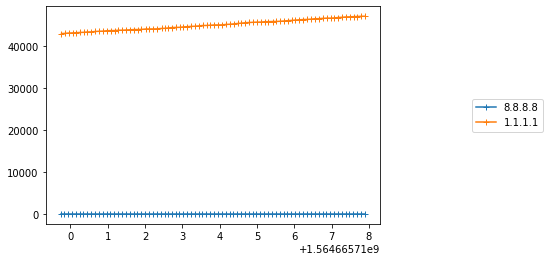

In [21]:
%matplotlib inline
ans.multiplot(lambda x, y: (y[IP].src, (y.time, y[IP].id)), plot_xy=True)

- the `raw()` function builds a packet, as sent on the network

In [22]:
pkt = IP() / UDP() / DNS(qd=DNSQR())
repr(raw(pkt))

"b'E\\x00\\x00=\\x00\\x01\\x00\\x00@\\x11|\\xad\\x7f\\x00\\x00\\x01\\x7f\\x00\\x00\\x01\\x005\\x005\\x00)\\xb6\\xd3\\x00\\x00\\x01\\x00\\x00\\x01\\x00\\x00\\x00\\x00\\x00\\x00\\x03www\\x07example\\x03com\\x00\\x00\\x01\\x00\\x01'"

This representation being complicated, Scapy can:
   -  do a `hexdump` of the content

In [23]:
hexdump(pkt)

0000  45 00 00 3D 00 01 00 00 40 11 7C AD 7F 00 00 01  E..=....@.|.....
0010  7F 00 00 01 00 35 00 35 00 29 B6 D3 00 00 01 00  .....5.5.)......
0020  00 01 00 00 00 00 00 00 03 77 77 77 07 65 78 61  .........www.exa
0030  6D 70 6C 65 03 63 6F 6D 00 00 01 00 01           mple.com.....


  - dump fields content layer by layer

In [24]:
pkt.show()

###[ IP ]### 
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = udp
  chksum    = None
  src       = 127.0.0.1
  dst       = 127.0.0.1
  \options   \
###[ UDP ]### 
     sport     = domain
     dport     = domain
     len       = None
     chksum    = None
###[ DNS ]### 
        id        = 0
        qr        = 0
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 1
        ra        = 0
        z         = 0
        ad        = 0
        cd        = 0
        rcode     = ok
        qdcount   = 1
        ancount   = 0
        nscount   = 0
        arcount   = 0
        \qd        \
         |###[ DNS Question Record ]### 
         |  qname     = 'www.example.com'
         |  qtype     = A
         |  qclass    = IN
        an        = None
        ns        = None
        ar        = None



  - display a pretty representation

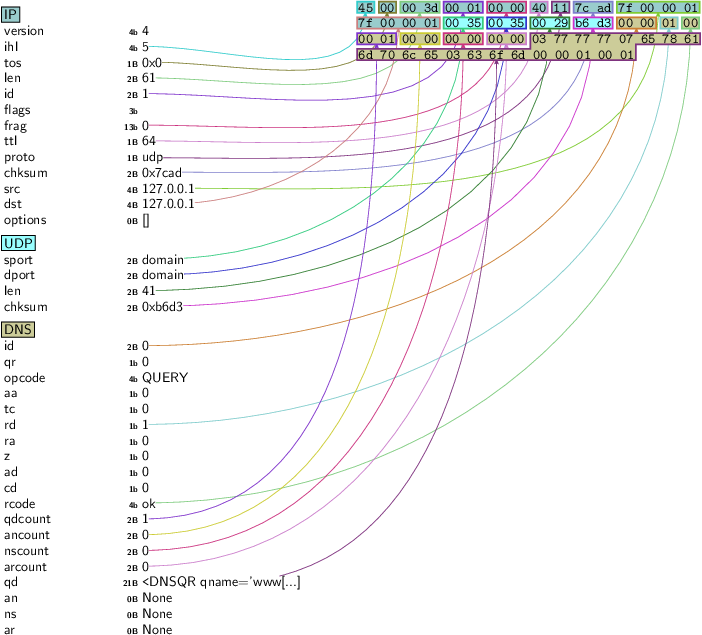

In [14]:
pkt.canvas_dump()

The `traceroute()` functions calls `sr(IP(ttl=(1,15))` and create the `TracerouteResult` object

---

In [25]:
ans, unans = traceroute('www.secdev.org', maxttl=15)

Begin emission:
Finished sending 15 packets.

Received 20 packets, got 14 answers, remaining 1 packets
   217.25.178.5:tcp80 
1  192.168.42.1    11 
3  193.253.82.102  11 
4  193.252.159.153 11 
5  193.252.137.78  11 
6  130.117.15.233  11 
7  154.25.7.150    11 
8  154.25.4.254    11 
9  149.6.166.166   11 
10 217.25.178.5    SA 
11 217.25.178.5    SA 
12 217.25.178.5    SA 
13 217.25.178.5    SA 
14 217.25.178.5    SA 
15 217.25.178.5    SA 


Different methods can be used to display the results, like `world_trace()` that uses the GeoIP module from [MaxMind](https://www.maxmind.com/), and [cartopy](https://pypi.org/project/Cartopy/)

---

[[<matplotlib.lines.Line2D at 0x7fb432ee41d0>]]

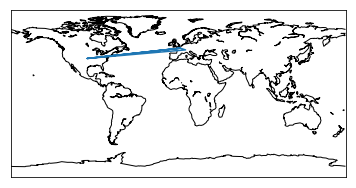

In [22]:
%matplotlib inline
ans.world_trace()

The `make_table()` method provides a compact results representation, useful for a basic *port scanner*

---

In [27]:
targets = ["scanme.nmap.org", "nmap.org"]

ans = sr(IP(dst=targets) / TCP(dport=[22, 80, 443, 31337]), timeout=3, verbose=False)[0]

ans.extend(sr(IP(dst=targets) / UDP() / DNS(qd=DNSQR()), timeout=3, verbose=False)[0])

ans.make_table(lambda x, y: (x[IP].dst,
                             x.sprintf('%IP.proto%/{TCP:%r,TCP.dport%}{UDP:%r,UDP.dport%}'),
                             y.sprintf('{TCP:%TCP.flags%}{ICMP:%ICMP.type%}')))

          45.33.32.156 45.33.49.119 
tcp/22    SA           SA           
tcp/31337 SA           RA           
tcp/443   RA           SA           
tcp/80    SA           SA           
udp/53    dest-unreach -            


## Scapy as a Python module

Scapy can be used to build your own tools like `ping6.py`:

---

In [35]:
import argparse                                                                 
                                                                                
from scapy.all import *                                                         
                                                                                
parser = argparse.ArgumentParser(description="A simple ping6")                  
parser.add_argument("ipv6_host", help="An IPv6 address")
args = parser.parse_args()                                                      
                                                                                
print(sr1(IPv6(dst=args.ipv6_host) / ICMPv6EchoRequest(), verbose=0).summary())

```shell
sudo python ping6.py www.kame.net
IPv6 / ICMPv6 Echo Reply (id: 0x0 seq: 0x0)
```

# Implementing a new protocol

To add new protocols, create an object:
- that inherits from `Packet`
- defines fields in the `fields_desc` variable

---

In [36]:
class DNSTCP(Packet):
    name = "DNS over TCP"
    
    fields_desc = [ FieldLenField("len", None, fmt="!H", length_of="dns"),
                    PacketLenField("dns", 0, DNS, length_from=lambda p: p.len)]
    
    # This method tells Scapy to decode the payload with DNSTCP
    def guess_payload_class(self, payload):
        return DNSTCP

This new protocol can be directly used to build and parse a packet

---

In [37]:
DNSTCP(raw(DNSTCP(dns=DNS())))

<DNSTCP  len=12 dns=<DNS  id=0 qr=0 opcode=QUERY aa=0 tc=0 rd=1 ra=0 z=0 ad=0 cd=0 rcode=ok qdcount=0 ancount=0 nscount=0 arcount=0 |> |>

The `StreamSocket` object allows Scapy to use a TCP socket

---

In [38]:
import socket

from scapy.all import *

sck = socket.socket(socket.AF_INET, socket.SOCK_STREAM)  # create a TCP socket
sck.connect(("8.8.8.8", 53))  # connect to 8.8.8.8 on 53/TCP

# Create a StreamSocket and define the default class
ssck = StreamSocket(sck)
ssck.basecls = DNSTCP

# Send the DNS query
ssck.sr1(DNSTCP(dns=DNS(qd=DNSQR(qname="www.example.com"))))

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets


<DNSTCP  len=49 dns=<DNS  id=0 qr=1 opcode=QUERY aa=0 tc=0 rd=1 ra=1 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=1 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=<DNSRR  rrname='www.example.com.' type=A rclass=IN ttl=5713 rdlen=None rdata=93.184.216.34 |> ns=None ar=None |> |>

## Answering Machines

Scapy can wait for a query, then send an answer with the `AnsweringMachine` object.

Two methods are mandatory:
1. `is_request()`: returns `True` if the packet is the expected query
2. `make_reply()`: returns the packet that will be sent by Scapy


Note: in the following example, the Wi-Fi interface must be put in *monitor* mode

In [ ]:
from scapy.all import *

# Specify the Wi-Fi interface
conf.iface = "mon0"

# Create the Answering Machine
class ProbeRequest_am(AnsweringMachine):
  function_name = "pram"

  mac = "00:11:22:33:44:55"

  def is_request(self, pkt):
    return Dot11ProbeReq in pkt

  def make_reply(self, req):

    rep = RadioTap()
    # Note: depending on your Wi-Fi card, you might need something else than RadioTap()
    rep /= Dot11(addr1=req.addr2, addr2=self.mac, addr3=self.mac, ID=RandShort(), SC=RandShort())
    rep /= Dot11ProbeResp(cap="ESS", timestamp=time.time())
    rep /= Dot11Elt(ID="SSID",info="Scapy !")
    rep /= Dot11Elt(ID="Rates",info='\x82\x84\x0b\x16\x96')
    rep /= Dot11Elt(ID="DSset",info=chr(10))

    return rep

# Start the answering machine
#ProbeRequest_am()()  # uncomment to test

![](images/scapy_am.png)

# IPv6 Reconnaissance

- discover the link IPv6 router using the Router Solicitation message

---

In [39]:
sr1(IPv6()/ICMPv6ND_RS())

Begin emission:
Finished sending 1 packets.

Received 2 packets, got 1 answers, remaining 0 packets


<IPv6  version=6 tc=192 fl=0 plen=104 nh=ICMPv6 hlim=255 src=fe80::ba26:6cff:fe5f:4eee dst=ff02::1 |<ICMPv6ND_RA  type=Router Advertisement code=0 cksum=0x4199 chlim=64 M=0 O=1 H=0 prf=High P=0 res=0 routerlifetime=600 reachabletime=0 retranstimer=0 |<ICMPv6NDOptPrefixInfo  type=3 len=4 prefixlen=64 L=1 A=1 R=0 res1=0 validlifetime=0x708 preferredlifetime=0x258 res2=0x0 prefix=2a01:cb08:229:3700:: |<ICMPv6NDOptRDNSS  type=25 len=3 res=0 lifetime=600 dns=[ fe80::ba26:6cff:fe5f:4eee ] |<ICMPv6NDOptDNSSL  type=31 len=2 res=0 lifetime=600 searchlist=['home.'] |<ICMPv6NDOptMTU  type=5 len=1 res=0x0 mtu=1500 |<ICMPv6NDOptSrcLLAddr  type=1 len=1 lladdr=b8:26:6c:5f:4e:ee |>>>>>>>

- probe local nodes and list manufacturers

---

In [40]:
a,u = sr(IPv6(dst="ff02::1")/ICMPv6EchoRequest(), multi=1, timeout=1)
a.make_table(lambda t: (t[0][IPv6].dst, t[1][IPv6].src, in6_addrtovendor(t[1][IPv6].src)))

Begin emission:
Finished sending 1 packets.

Received 6 packets, got 0 answers, remaining 1 packets
 


# X.509 Certificates Manipulation

- Scapy can easily parse certificates, and display their contents

---

In [1]:
load_layer("tls")
cert_blackhat = Cert(pem2der(open("files/blackhat.com.pem", "rb").read()))  # assuming you d/l the certificate
cert_blackhat

[X.509 Cert. Subject:/OU=PositiveSSL Multi-Domain/CN=ssl764995.cloudflaressl.com, Issuer:/C=GB/ST=Greater Manchester/L=Salford/O=COMODO CA Limited/CN=COMODO ECC Domain Validation Secure Server CA 2]

- several useful methods help exploring them

---

In [2]:
print(cert_blackhat.isSelfSigned())  # check if it is self signed
print(cert_blackhat.subject)  # display the subject
print(cert_blackhat.remainingDays()) # compute the number of days until expiration

False
{'organizationUnitName': 'PositiveSSL Multi-Domain', 'commonName': 'ssl764995.cloudflaressl.com'}
156.39600694444445


- look for the Subject Alternative Name extension
---

In [3]:
[e  for e in cert_blackhat.tbsCertificate.extensions if e.extnID == "2.5.29.17"]

[<X509_Extension  extnID=<ASN1_OID['subjectAltName']> critical=None extnValue=<X509_ExtSubjectAltName  subjectAltName=[<X509_GeneralName  generalName=<X509_DNSName  dNSName=<ASN1_IA5_STRING[b'ssl764995.cloudflaressl.com']> |> |>, <X509_GeneralName  generalName=<X509_DNSName  dNSName=<ASN1_IA5_STRING[b'*.blackhat.com']> |> |>, <X509_GeneralName  generalName=<X509_DNSName  dNSName=<ASN1_IA5_STRING[b'blackhat.com']> |> |>] |> |>]

- moreover, some cryptographic tricks are also included, like verifying signatures:

---

In [4]:
# Verify issuers signatures
cert_comodo = Cert(pem2der(open("files/comodo.pem", "rb").read())) # assuming you d/l the certificate        
print(cert_blackhat.isIssuerCert(cert_comodo))  # check the signature

True


- or, change the certificate signature:

---

In [5]:
cert_blackhat.tbsCertificate.serialNumber.val = 0x42  # Change a value

private_key = PrivKeyRSA("files/private_key.pem")  # Load a private key
new_cert_blackhat = private_key.resignCert(cert_blackhat)  # Do a new signature

print(hex(new_cert_blackhat.tbsCertificate.serialNumber.val))  # Print the value
print(private_key.verifyCert(new_cert_blackhat))  # Verify the signature

0x42
True


# HTTP & TLS tricks

- since Scapy v2.4.3, it is possible to perform HTTP queries
---

In [6]:
load_layer("http")
req = HTTP() / HTTPRequest(
    Accept_Encoding=b'gzip, deflate',
    Cache_Control=b'no-cache',
    Pragma=b'no-cache',
    Connection=b'keep-alive',
    Host=b'www.secdev.org',
)
t = TCP_client.tcplink(HTTP, "www.secdev.org", 80)
r = t.sr1(req, timeout=3)

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets


In [66]:
r[HTTPResponse].show()

###[ HTTP Response ]### 
  Http_Version= 'HTTP/1.1'
  Status_Code= '200'
  Reason_Phrase= 'OK'
  Accept_Patch= None
  Accept_Ranges= 'bytes'
  Access_Control_Allow_Credentials= None
  Access_Control_Allow_Headers= None
  Access_Control_Allow_Methods= None
  Access_Control_Allow_Origin= None
  Access_Control_Expose_Headers= None
  Access_Control_Max_Age= None
  Age       = None
  Allow     = None
  Alt_Svc   = None
  Cache_Control= None
  Connection= 'Keep-Alive'
  Content_Disposition= None
  Content_Encoding= 'gzip'
  Content_Language= None
  Content_Length= '5351'
  Content_Location= None
  Content_MD5= None
  Content_Range= None
  Content_Security_Policy= None
  Content_Type= 'text/html'
  Date      = 'Thu, 25 Jul 2019 13:00:35 GMT'
  Delta_Base= None
  ETag      = '"300a-56be3867f3785-gzip"'
  Expires   = None
  IM        = None
  Keep_Alive= 'timeout=5, max=100'
  Last_Modified= 'Fri, 11 May 2018 00:50:41 GMT'
  Link      = None
  Location  = None
  P3P       = None
  Permanent = N

- sniff TLS traffic

---

In [11]:
load_layer("tls")
s = sniff(filter="port 443", count=100)  # sniff packets on port 443
ch_list = [p for p in s if TLSClientHello in p]  # filter Client Hello messages
ch_list[0][TLSClientHello].show()  # display the first message

###[ TLS Handshake - Client Hello ]### 
  msgtype   = client_hello
  msglen    = 508
  version   = TLS 1.2
  gmt_unix_time= Sat, 10 Oct 2026 00:01:56 +0100 (1791590516)
  random_bytes= f8f3159aa9f5bde32af8db592a160d3100fbee52581db2579fde7767
  sidlen    = 32
  sid       = '\xc4\x8d\r\x81yl\x81\x1b\xc4\xb9vY\x83{V\xaf\xd9\xef\xfc--(\x16h\xc0\xdd\x8f\xe6\x85c\xdaA'
  cipherslen= 36
  ciphers   = [TLS_AES_128_GCM_SHA256, TLS_CHACHA20_POLY1305_SHA256, TLS_AES_256_GCM_SHA384, TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256, TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256, TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256, TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256, TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384, TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384, TLS_ECDHE_ECDSA_WITH_AES_256_CBC_SHA, TLS_ECDHE_ECDSA_WITH_AES_128_CBC_SHA, TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA, TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA, TLS_DHE_RSA_WITH_AES_128_CBC_SHA, TLS_DHE_RSA_WITH_AES_256_CBC_SHA, TLS_RSA_WITH_AES_128_CBC_SHA, TLS_RSA_WITH_AES_256_CBC_S

# Projects That Uses Scapy

Wi-Fi & Bluetooth
- Clients deauthentication - https://github.com/DanMcInerney/wifijammer
- Rogue Access Points - https://github.com/wifiphisher/wifiphisher & https://github.com/P0cL4bs/WiFi-Pumpkin
- BT/BLE Attacks - https://redmine.laas.fr/projects/mirage

IPv6
- Windows MITM - https://github.com/fox-it/mitm6
- Assessment framework - https://github.com/aatlasis/Chiron


Audits & Attacks
- KRACK - https://github.com/vanhoefm/krackattacks-scripts
- LLMNR & MDNS poisoner - https://github.com/SpiderLabs/Responder
- 802.1x bypass - https://github.com/Orange-Cyberdefense/fenrir-ocd
- RADIUS - https://github.com/ANSSI-FR/audit-radius

# Questions?
# Issues?
# Pull Requests?
# Beers?